In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def importImage(path):
    images = []
    file_names = os.listdir(path)
    i = 0
    for file_name in file_names:
        i+=1
        file_path = os.path.join(path, file_name)
        image = cv2.imread(file_path)
        images.append(image)
        if i == 144 : break
    return images


In [3]:
imageRed = importImage("traffic_light_data/train/red")
imageYellow = importImage("traffic_light_data/train/yellow")
imageGreen = importImage("traffic_light_data/train/green")

In [4]:
def displayImage(images):
    plt.figure(figsize=(8, 8))
    for i in range(len(images)):
        plt.subplot(12, 12, i+1)
        bgr_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(bgr_image)
    plt.show()


In [5]:
def resizeImage(images):
    images_resize = []
    for image in images:
        image_resize = cv2.resize(image,(200,400))
        images_resize.append(image_resize)
    return images_resize

In [6]:
imageRed_resize = resizeImage(imageRed)
imageYellow_resize = resizeImage(imageYellow)
imageGreen_resize = resizeImage(imageGreen)

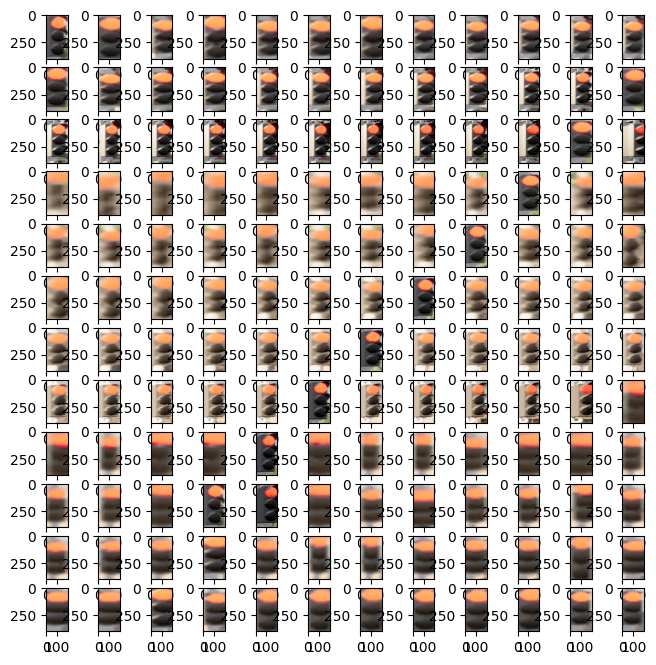

In [7]:
displayImage(imageRed_resize)

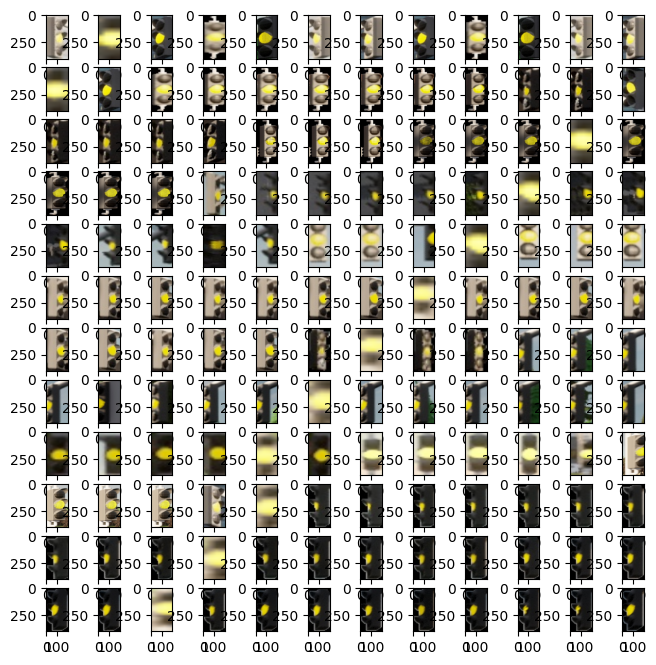

In [8]:
displayImage(imageYellow_resize)

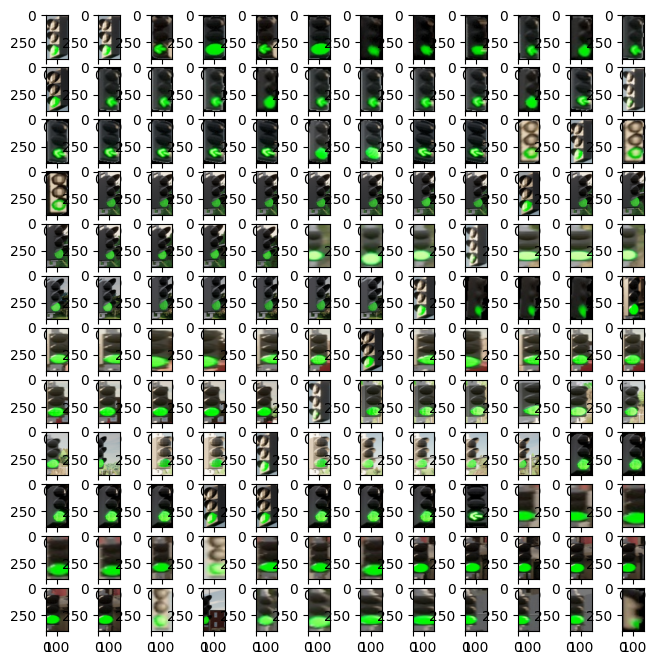

In [9]:
displayImage(imageGreen_resize)

In [10]:
def noiseRemoval(images):
    images_noise = []
    for image in images:
        image_noise = cv2.GaussianBlur(image, (5, 5), 0)
        images_noise.append(image_noise)
    return images_noise

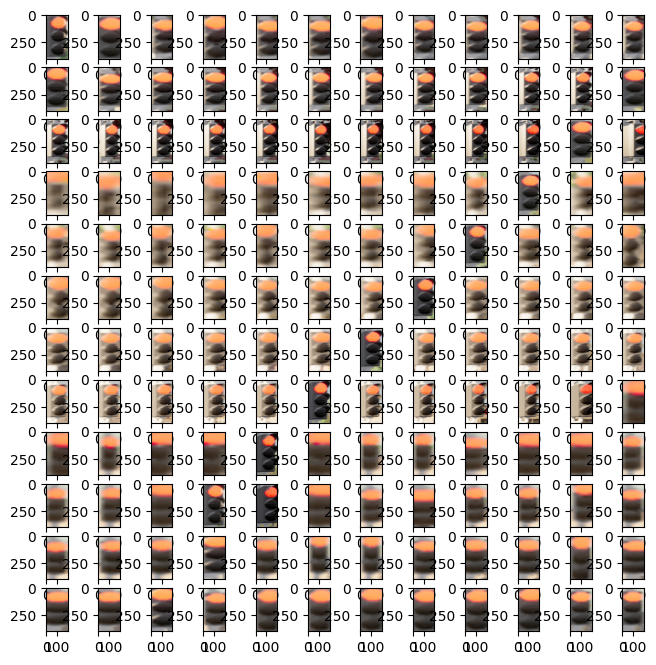

In [11]:
blurRed = noiseRemoval(imageRed_resize)
displayImage(blurRed)

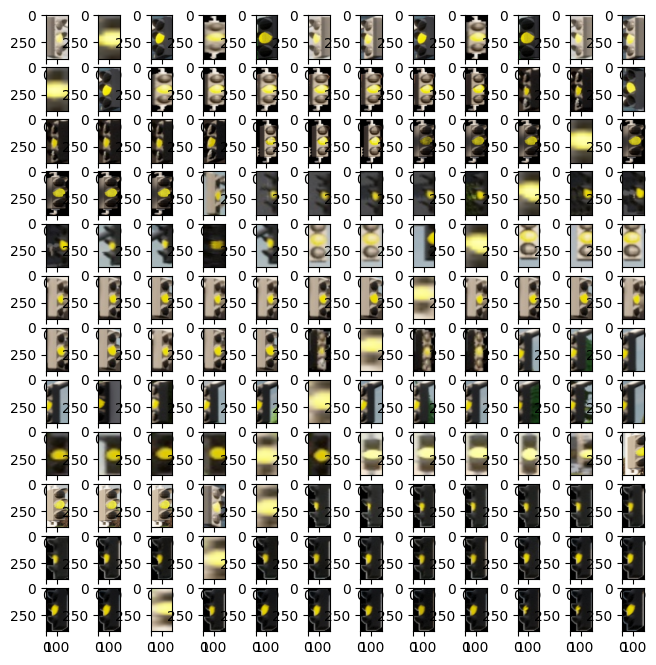

In [12]:
blurYellow = noiseRemoval(imageYellow_resize)
displayImage(blurYellow)

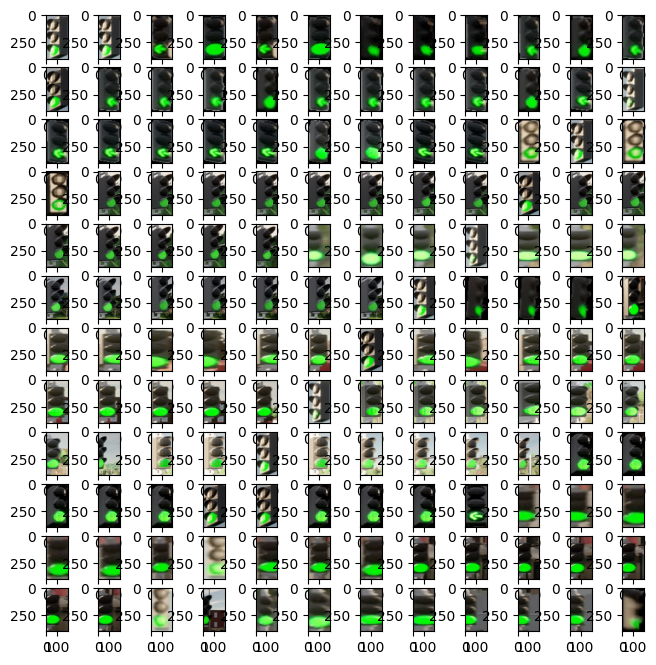

In [13]:
blurGreen = noiseRemoval(imageGreen_resize)
displayImage(blurGreen)

In [14]:
def contrastEnhancement(images):
    images_contrast = []
    for image in images:
        image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(image_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab_planes = list(lab_planes)
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab_planes = tuple(lab_planes)
        image_lab = cv2.merge(lab_planes)
        image_contrast = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
        images_contrast.append(image_contrast)
    return images_contrast


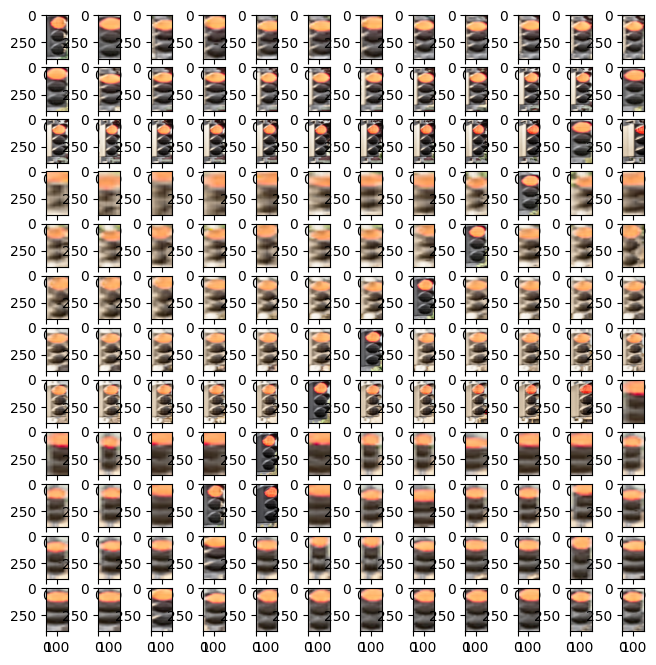

In [15]:
contrastRed = contrastEnhancement(blurRed)
displayImage(contrastRed)

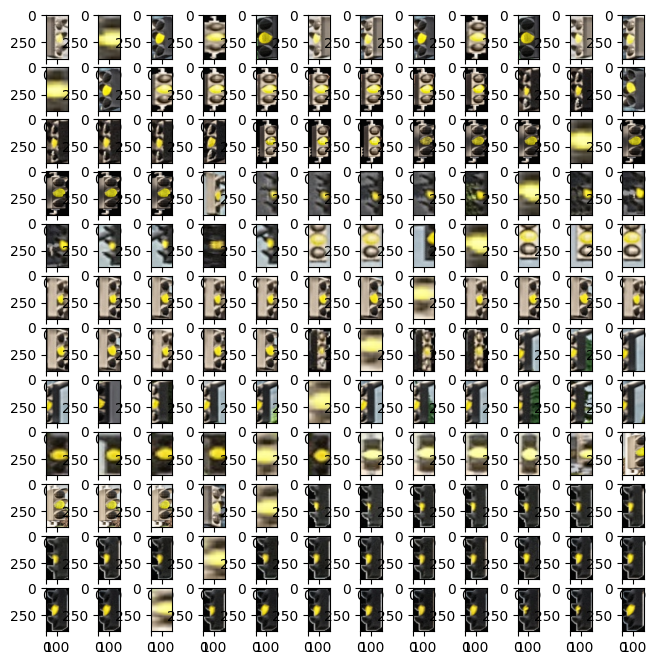

In [16]:
contrastYellow = contrastEnhancement(blurYellow)
displayImage(contrastYellow)

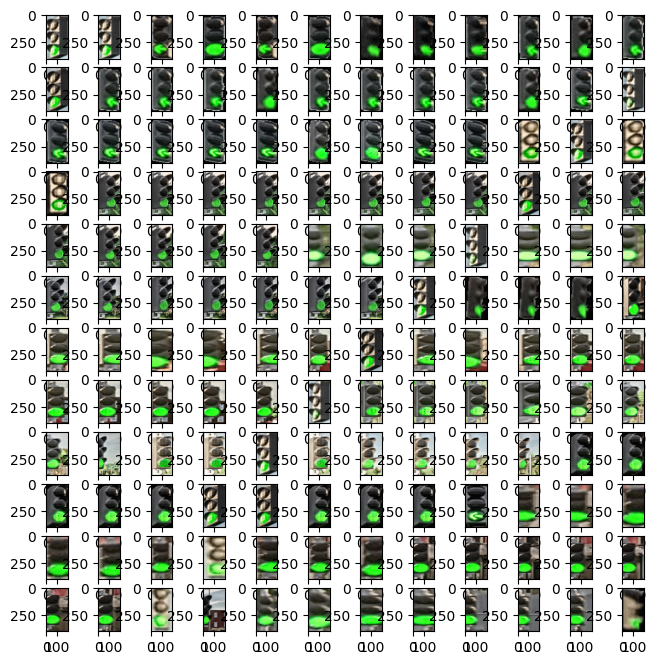

In [17]:
contrastGreen = contrastEnhancement(blurGreen)
displayImage(contrastGreen)

In [18]:
def saturationEnhancement(images):
    images_saturation = []
    for image in images:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image_hsv)
        saturation_factor = 1.5
        s = np.clip(s.astype(np.float32) * saturation_factor, 0, 255)
        s = np.clip(s, 0, 255).astype(np.uint8)
        image_hsv = cv2.merge([h, s, v])
        image_saturated = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)
        images_saturation.append(image_saturated)
    return images_saturation


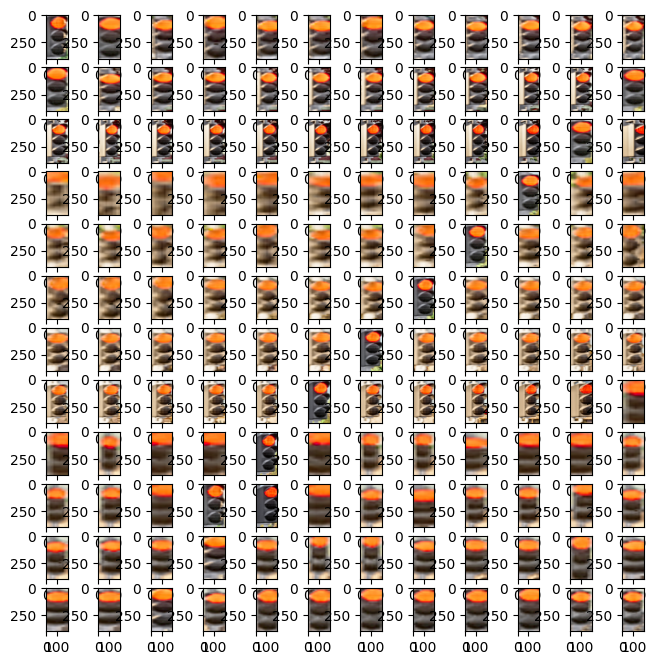

In [19]:
saturationRed = saturationEnhancement(contrastRed)
displayImage(saturationRed)

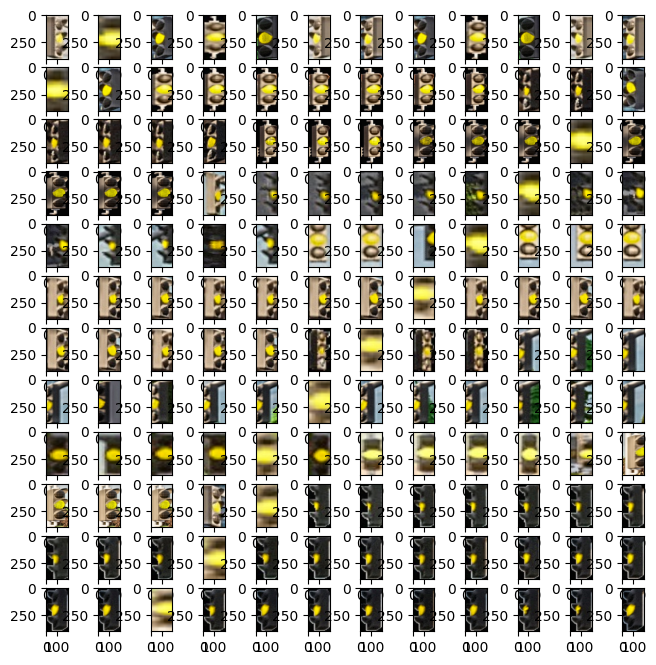

In [20]:
saturationYellow = saturationEnhancement(contrastYellow)
displayImage(saturationYellow)

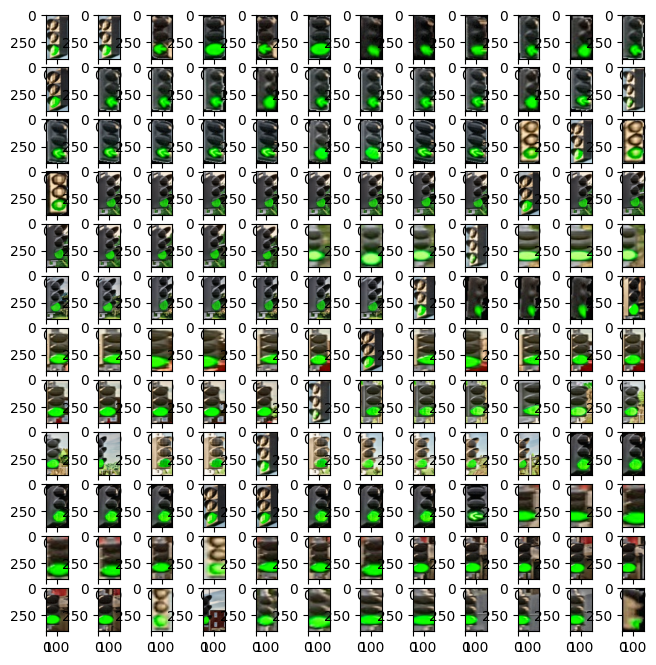

In [21]:
saturationGreen = saturationEnhancement(contrastGreen)
displayImage(saturationGreen)

In [22]:
def segmentColor(images):
    images_segment = []
    for image in images:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_red = np.array([0, 100, 20])
        upper_red = np.array([179, 255, 255])
        mask_red = cv2.inRange(image_hsv, lower_red, upper_red)
        lower_green = np.array([50, 100, 100])
        upper_green = np.array([70, 255, 255])
        mask_green = cv2.inRange(image_hsv, lower_green, upper_green)
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([30, 255, 255])
        mask_yellow = cv2.inRange(image_hsv, lower_yellow, upper_yellow)
        mask = mask_red + mask_green + mask_yellow
        image_segment = cv2.bitwise_and(image, image, mask=mask)
        images_segment.append(image_segment)
    return images_segment



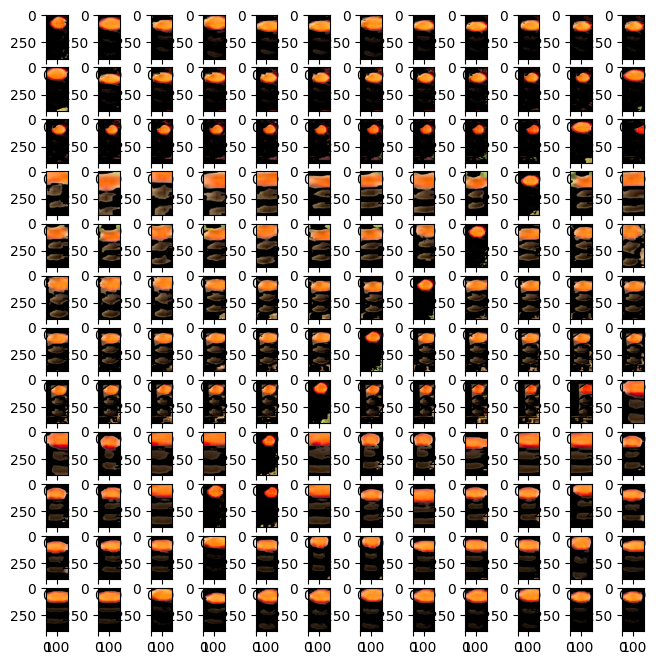

In [23]:
segmentRed = segmentColor(saturationRed)
displayImage(segmentRed)

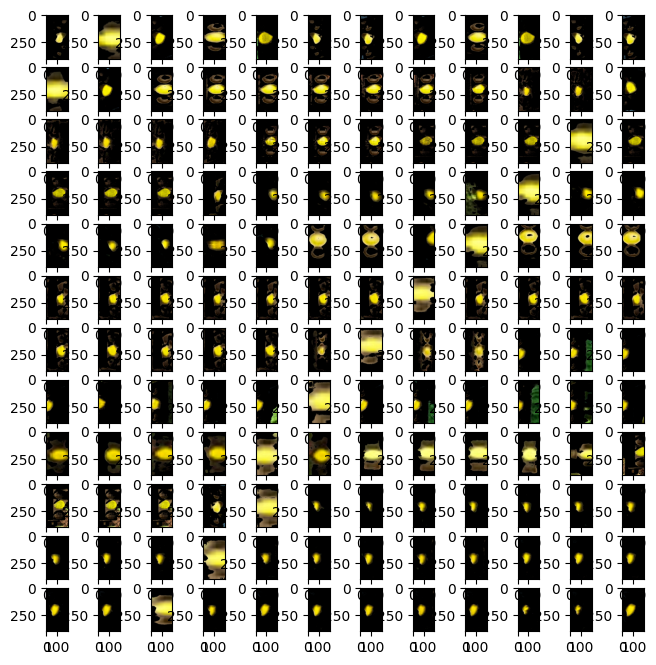

In [24]:
segmentYellow = segmentColor(saturationYellow)
displayImage(segmentYellow)

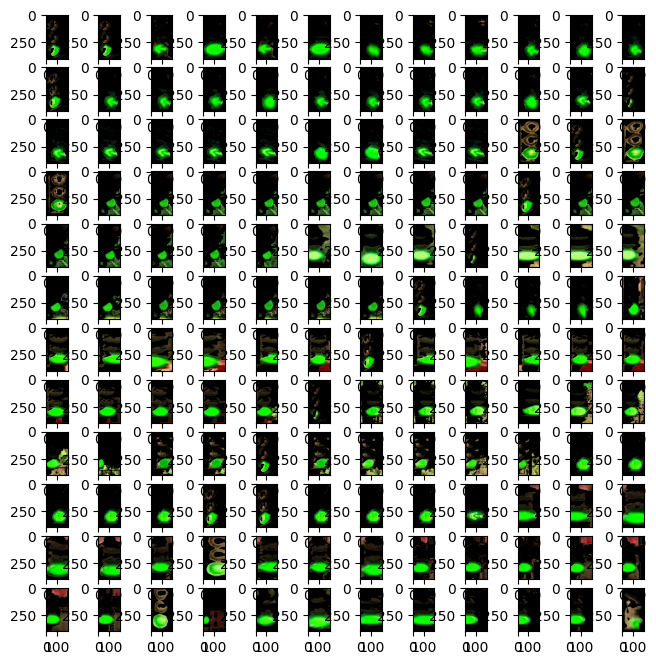

In [25]:
segmentGreen = segmentColor(saturationGreen)
displayImage(segmentGreen)

In [26]:
def erodeImage(images):
    images_erode = []
    kernel = np.ones((20, 20), np.uint8)
    for image in images:
        image_erode = cv2.erode(image, kernel, iterations=1)
        images_erode.append(image_erode)
    return images_erode

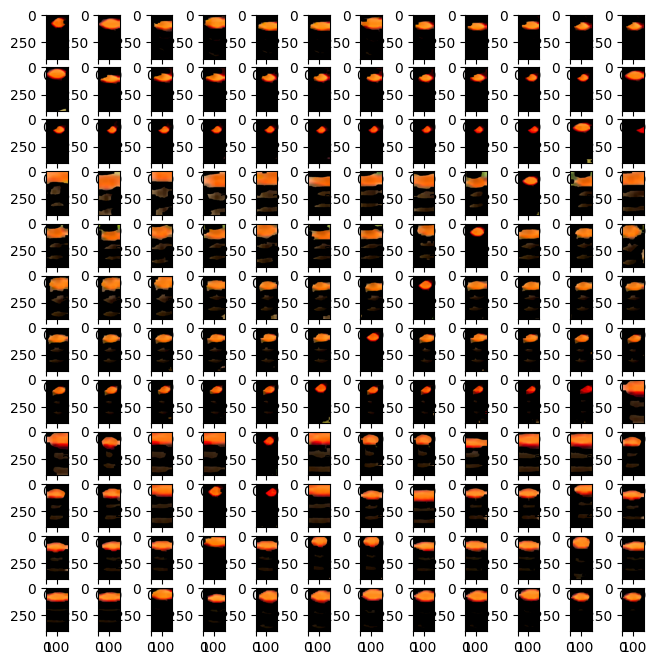

In [27]:
erodeRed = erodeImage(segmentRed)
displayImage(erodeRed)

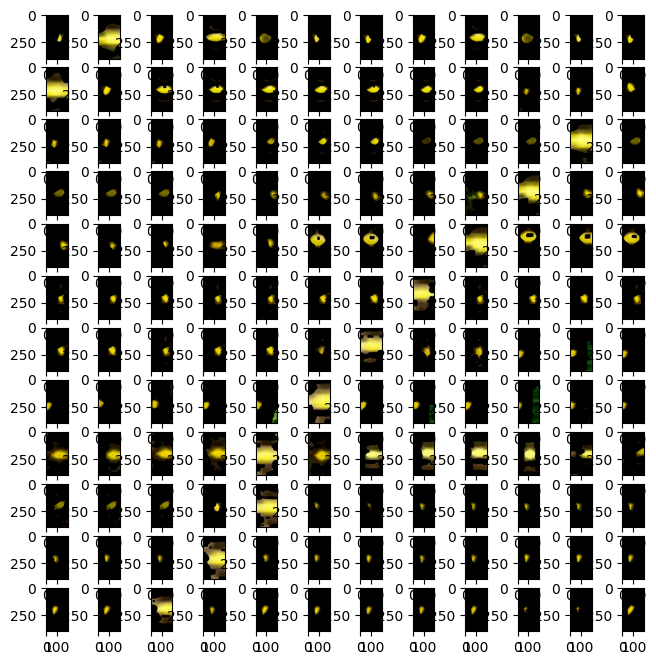

In [28]:
erodeYellow = erodeImage(segmentYellow)
displayImage(erodeYellow)

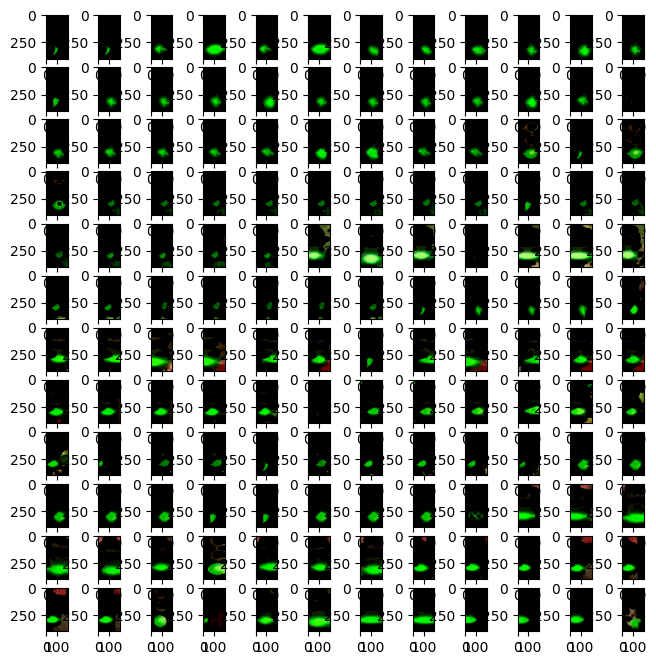

In [29]:
erodeGreen = erodeImage(segmentGreen)
displayImage(erodeGreen)

In [30]:
def recognizeTrafficLightColor(red_images, yellow_images, green_images):
    labels = [0, 1, 2]

    features = []
    target_labels = []

    for image in red_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[0])

    for image in yellow_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[1])

    for image in green_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[2])

    X_train, X_test, y_train, y_test = train_test_split(features, target_labels, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)

    return model, scaler

In [31]:
model, scaler = recognizeTrafficLightColor(erodeRed, erodeYellow, erodeGreen)    

In [32]:
def allProcess(images):
    images_resize = resizeImage(images)
    images_noise = noiseRemoval(images_resize)
    images_contrast = contrastEnhancement(images_noise)
    images_saturation = saturationEnhancement(images_contrast)
    images_segment = segmentColor(images_saturation)
    images_erode = erodeImage(images_segment)
    return images_erode

In [33]:
def predictRandomTrafficLightColor(images, model, scaler):
    images = allProcess(images)
    predict = []
    for image in images:
        avg_color = np.mean(image, axis=(0, 1))
        scaled_color = scaler.transform([avg_color])
        predicted_label = model.predict(scaled_color)
        if predicted_label[0] == 0:
            predict.append("red")
        elif predicted_label[0] == 1:
            predict.append("yellow")
        elif predicted_label[0] == 2:
            predict.append("green")
        else:
            predict.append("unknown")
    return predict

In [34]:
def randImage():
    folder = ["red", "yellow", "green"]
    real_color = []
    random_images = []
    for i in range(144):    
        folder_rand = random.choice(folder)
        real_color.append(folder_rand)
        path = f"traffic_light_data/train/{folder_rand}/"
        random_image = random.choice(os.listdir(path))
        random_image_path = os.path.join(path, random_image)
        random_image = cv2.imread(random_image_path)
        random_images.append(random_image)
    return random_images, real_color

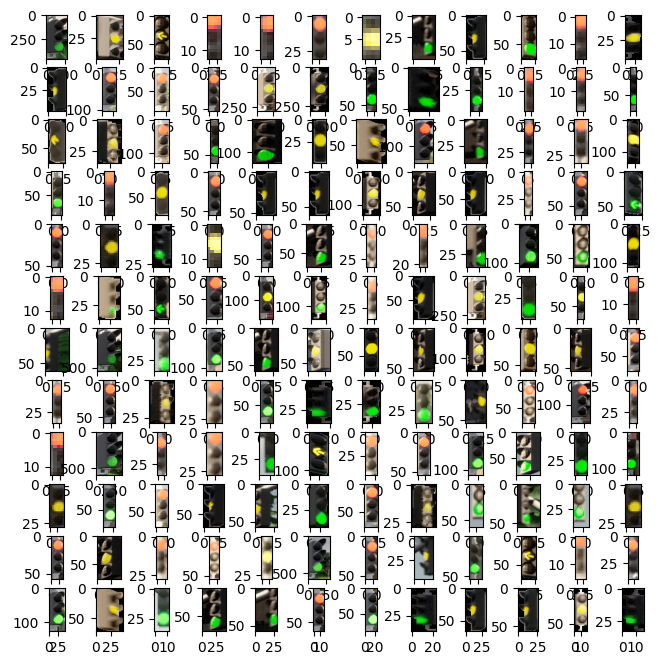

In [39]:
random_images,real_color = randImage()
displayImage(random_images)

In [40]:
predicted_color = predictRandomTrafficLightColor(random_images, model, scaler)
print("real\t:",real_color)
print("predict\t:",predicted_color)

real	: ['green', 'yellow', 'yellow', 'red', 'red', 'red', 'yellow', 'green', 'yellow', 'green', 'red', 'yellow', 'yellow', 'red', 'red', 'red', 'yellow', 'yellow', 'green', 'green', 'green', 'red', 'red', 'green', 'yellow', 'yellow', 'red', 'green', 'green', 'yellow', 'yellow', 'red', 'green', 'red', 'red', 'yellow', 'green', 'red', 'yellow', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'red', 'red', 'green', 'red', 'yellow', 'green', 'yellow', 'red', 'green', 'red', 'red', 'green', 'green', 'green', 'yellow', 'red', 'green', 'green', 'red', 'yellow', 'green', 'red', 'yellow', 'yellow', 'green', 'yellow', 'red', 'yellow', 'green', 'green', 'green', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'red', 'red', 'red', 'yellow', 'red', 'green', 'green', 'green', 'green', 'yellow', 'red', 'red', 'red', 'red', 'green', 'red', 'red', 'green', 'yellow', 'red', 'red', 'green', 'green', 'green', 'green', 'yellow', 'green', 'red', 'yellow', 'yellow', 'green', 're

In [41]:
def calculateAccuracy(real_color, predicted_color):
    correct = 0
    for i in range(len(real_color)):
        if real_color[i] == predicted_color[i]:
            correct += 1
    accuracy = correct / len(real_color)
    return accuracy

In [42]:
accuracy = calculateAccuracy(real_color, predicted_color)
print("accuracy:",accuracy)

accuracy: 0.9722222222222222
